In [1]:
FN0 = 'tokens'

In [2]:
FN = 'vocabulary-embedding'

In [3]:
seed=42
vocab_size = 40000#200000
embedding_dim = 100
lower = False # dont lower case the text

## Read headlines and descriptions

In [4]:
import pickle as pickle
with open('data/%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp)

In [5]:
if lower:
    heads = [h.lower() for h in heads]
    desc = [d.lower() for d in desc]

In [6]:
i=0
heads[i]

'worcester breakfast club for veterans gives hunger its marching orders'

In [7]:
desc[i]

"veterans saluted worcester 's first ever breakfast club for ex-soldiers which won over hearts , minds and bellies . the worcester breakfast club for hm forces veterans met at the postal order in foregate street at 10am on saturday . the club is designed to allow veterans a place to meet , socialise , eat and drink , giving hunger and loneliness their marching orders . father-of-two dave carney , a"

In [8]:
len(heads), len(set(heads))

(1000000, 796471)

In [9]:
len(desc), len(set(desc))

(1000000, 851288)

## Build Vocabulary

In [10]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [11]:
vocab, vocabcount = get_vocab(heads+desc)

In [12]:
len(vocab)

926902

Most popular tokens

In [13]:
print(vocab[:50])
print('...', len(vocab))

['the', ',', '.', 'to', 'of', 'a', 'and', 'in', 'for', 'on', ':', 'is', '(', ')', 'at', 'with', "'s", '’', 'that', 'by', 'it', 'as', 'has', 'from', 's', 'was', 'this', 'new', '2015', 'will', 'are', 'be', 'an', 'i', 'you', 'have', '-', 'his', '``', "''", 'he', 'after', 'their', 'its', 'september', 'but', 'more', '$', 'one', 'we']
... 926902


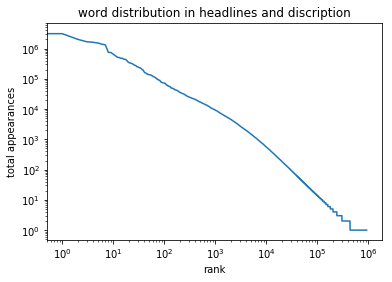

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

## Index words

In [15]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [16]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [17]:
word2idx, idx2word = get_idx(vocab, vocabcount)

## Word Embedding

### Setup GloVe

In [18]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

In [19]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [20]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [21]:
glove_embedding_weights.std()

0.040815727600190289

In [22]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## Embedding Matrix

Use GloVe to init embedding matrix

In [23]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408138249575
number of tokens, in small vocab, found in glove and copied to embedding 37838 0.94595


In [24]:
glove_thr = 0.5

In [25]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix. Use cos distance of GloVe vectors.
Allow for the last nb_unknown_words words inside the embedding matrix to be considered to be outside. Dont accept distances below glove_thr

In [ ]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

manually check that the worst substitutions we are going to do are good enough

In [ ]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

In [ ]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

## Data

In [ ]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

In [ ]:
plt.hist(list(map(len,Y)),bins=50);

In [ ]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

In [ ]:
plt.hist(list(map(len,X)),bins=50);

In [ ]:
import pickle as pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [ ]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)